In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *
from tradebondpair import *

# <span style="color:red">Solution 1</span>

In [3]:
filepath_tsdata = r"C:\Users\HuYun\Desktop\Winter_2024\37400\homework2\treasury_ts_2015-08-15.xlsx"
info = pd.read_excel(filepath_tsdata,sheet_name='info',index_col=0)
tsdata = pd.read_excel(filepath_tsdata,sheet_name='database')
tsdata.columns = tsdata.columns.str.upper()

In [4]:
DATE0 = '2008-11-04'
tab = get_table(info,tsdata,DATE0)
tab

kytreasno,204046,204047
issue date,1985-08-15 00:00:00,2005-08-15 00:00:00
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.625,4.25
type,bond,note
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued interest,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706


In [5]:
financing = pd.DataFrame(dtype='float64',index=['long','short'])
financing['haircut'] = [.02,.02]
financing['repo'] = [.0015,.0010]
financing

,haircut,repo
long,0.02,0.0015
short,0.02,0.0010


In [7]:
keyLong = tab.loc['ytm'].astype('float64').idxmax()
keyShort = tab.loc['ytm'].astype('float64').idxmin()

In [8]:
LONGEQUITY = 1e6

balsheet, fmt = trade_balance_sheet(prices=tab.loc['dirty price'], durations=tab.loc['duration'], haircuts=financing['haircut'], long_equity=LONGEQUITY, key_long=keyLong, key_short=keyShort)
balsheet.style.format(fmt,na_rep='')

,equity,assets,contracts
204046,"$1,000,000.00","$50,000,000.00","346,707.81"
204047,"$-881,131.58","$-44,056,578.93","-412,112.66"


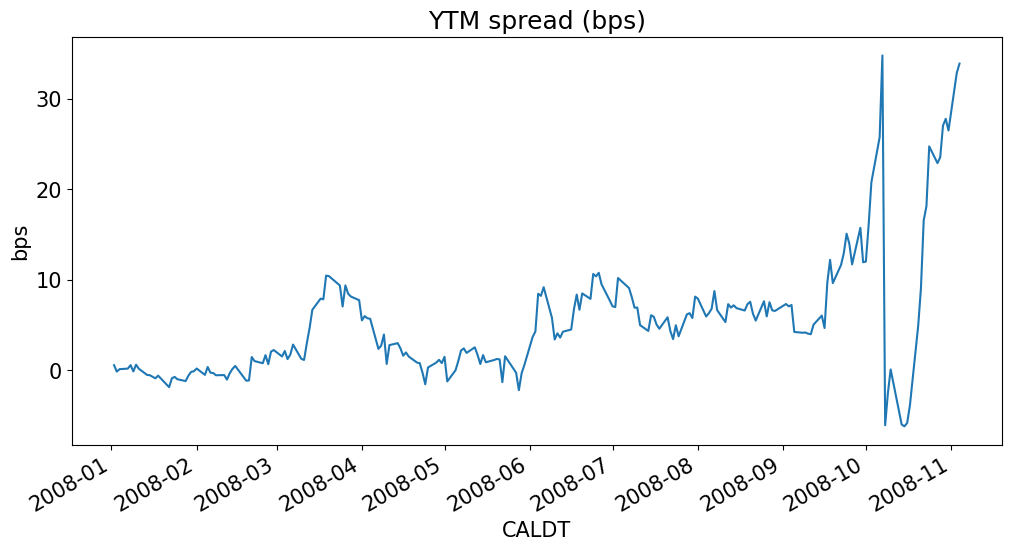

In [13]:
spread = get_spread_bps(tsdata)
spread = spread[keyShort]
spread.rename('ytm spread (bps)',inplace=True)
spread.loc['2008':'2008-11-04'].plot(ylabel='bps',title='YTM spread (bps)');

In [15]:
spread_convergence = tab.loc['ytm'].diff().dropna().abs().values[0]
pnl_spread_converges, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
pnl_spread_converges.style.format(fmt_dict,na_rep='')

,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.1695%,5.14,$144.21,"346,707.81","$435,509.58"
204047,0.1695%,5.84,$106.90,"-412,112.66","$436,236.08"
total,,,,,"$871,745.67"


In [16]:
spread_convergence = .0001

pnl_spread_1bp, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
pnl_spread_1bp.style.format(fmt_dict,na_rep='')

,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.0050%,5.14,$144.21,"346,707.81","$12,845.71"
204047,0.0050%,5.84,$106.90,"-412,112.66","$12,867.14"
total,,,,,"$25,712.85"


In [17]:
opportunity = pd.DataFrame([pnl_spread_converges.loc['total','pnl'], pnl_spread_1bp.loc['total','pnl']], columns=['pnl'],index=['converges','1bp'])
opportunity['return'] = opportunity['pnl'] / balsheet['equity'].abs().sum()
opportunity.style.format({'return':'{:.2%}','pnl':'${:,.2f}'})

,pnl,return
converges,"$871,745.67",46.34%
1bp,"$25,712.85",1.37%


In [19]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
bid = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDBID')
accint = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
dirty = (ask + bid)/2 + accint
dirty = dirty[[keyLong,keyShort]]

duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN')[[keyLong,keyShort]] / 365.25

In [21]:
n_weeks = 9
trade, fmt_dict = trade_evolution(DATE0, tab.loc['maturity date',keyShort], n_weeks, balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary = trade[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
summary.style.format(fmt,na_rep='')

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-11-10 00:00:00,"$-115,883.84",$0.00,"$-115,883.84",38.54
2008-11-18 00:00:00,"$-181,887.02",$0.00,"$-181,887.02",41.15
2008-11-25 00:00:00,"$-499,072.82",$0.00,"$-499,072.82",52.96
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-09 00:00:00,"$-903,774.22",$0.00,"$-903,774.22",67.29
2008-12-16 00:00:00,"$-1,049,332.75",$0.00,"$-1,049,332.75",71.61
2008-12-23 00:00:00,"$-805,707.20",$0.00,"$-805,707.20",63.50
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81


Yes, taking the data on November 25, 2008 as an example, YTM sprea expanded by about 20 performance points, and pnl also suffered a linear loss of about 499,000.

In [22]:
n_weeks = 35
trade_long, fmt_dict = trade_evolution(DATE0, tab.loc['maturity date',keyShort], n_weeks, balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary_long = trade_long[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
summary_long.iloc[::4,:].style.format(fmt,na_rep='')

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81
2009-01-27 00:00:00,"$20,657.36",$0.00,"$20,657.36",35.33
2009-02-24 00:00:00,"$-561,855.73","$966,145.83","$404,290.09",22.07
2009-03-24 00:00:00,"$-545,508.23","$966,145.83","$420,637.60",22.02
2009-04-21 00:00:00,"$-222,863.63","$966,145.83","$743,282.19",10.41
2009-05-19 00:00:00,"$22,192.58","$966,145.83","$988,338.41",1.32
2009-06-16 00:00:00,"$234,164.91","$966,145.83","$1,200,310.74",-7.14


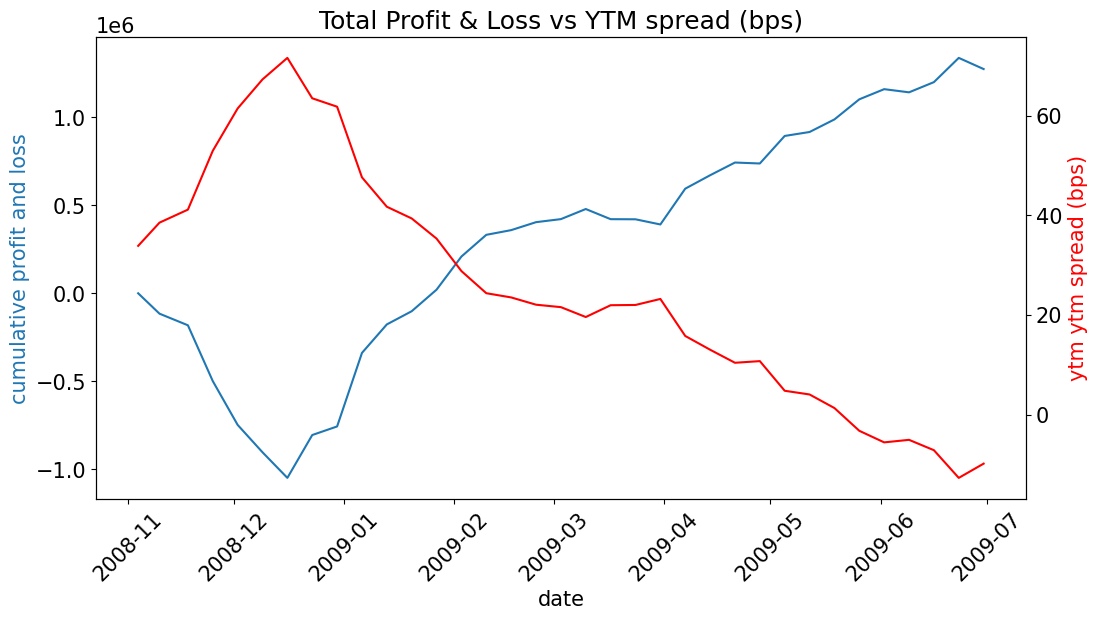

In [23]:
fig, ax = plt.subplots()

ax.plot(summary_long[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
ax2.plot(summary_long[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color());

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

Yes, according to the image, as the YTM spread shrinks, pnl also grows linearly.

# <span style="color:red">Solution 2</span>

In [25]:
filepath_tsdata = r"C:\Users\HuYun\Desktop\Winter_2024\37400\homework2\treasury_ts_issue_duration_(207392, 207391, 207404).xlsx"

info = pd.read_excel(filepath_tsdata,sheet_name='info').set_index('kytreasno')
info

,issue date,maturity date,coupon rate,security type
kytreasno,,,,
207392,2019-08-15,2049-08-15,2.250,1
207391,2019-08-15,2029-08-15,1.625,2
207404,2019-08-31,2024-08-31,1.250,2


In [26]:
SIZE = 10000
IDLONG = 207391
IDSHORT = 207392

FREQ = 365.25

In [27]:
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()/FREQ

In [28]:
position = pd.DataFrame(index=duration.index, dtype=float)

position['long'] = SIZE / px[IDLONG]
position['hedge ratio'] = (duration[IDLONG] / duration[IDSHORT]) * (px[IDLONG] / px[IDSHORT])
position['short'] = - position['hedge ratio'] * position['long']
position[['long ($)','short ($)']] = position[['long','short']] * px[[IDLONG,IDSHORT]].values

position['net ($)'] = position[['long ($)','short ($)']].sum(axis=1)
wts = position[['long ($)','short ($)']].div(position[['long ($)','short ($)']].sum(axis=1),axis=0)

In [29]:
position['duration'] = (wts * duration[[IDLONG,IDSHORT]].values).sum(axis=1)
position['duration'].describe().to_frame().T.style.format('{:.1%}')

,count,mean,std,min,25%,50%,75%,max
duration,106700.0%,-0.0%,0.0%,-0.0%,-0.0%,0.0%,0.0%,0.0%


In [30]:
position[['long ($) realized','short ($) realized']] = \
    position[['long','short']] * px[[IDLONG,IDSHORT]].shift(-1).values

position[['long p&l','short p&l']] = \
    position[['long ($) realized','short ($) realized']] - position[['long ($)','short ($)']].values

position['profit hedged'] = position[['long p&l','short p&l']].sum(axis=1)

In [31]:
position['profit'] = px[IDLONG].diff() * position['long'].shift()

position

,long,hedge ratio,short,long ($),short ($),net ($),duration,long ($) realized,short ($) realized,long p&l,short p&l,profit hedged,profit
CALDT,,,,,,,,,,,,,
2019-08-29,98.811178,0.395113,-39.041629,10000.0,-4156.713467,5843.286533,0.000000e+00,9998.456075,-4157.933518,-1.543925,-1.220051,-2.763976,NaN
2019-08-30,98.826436,0.394841,-39.020756,10000.0,-4155.710484,5844.289516,-1.776357e-15,10039.376158,-4164.551124,39.376158,-8.840640,30.535518,-1.543925
2019-09-03,98.438822,0.395185,-38.901579,10000.0,-4151.831759,5848.168241,0.000000e+00,9991.540414,-4136.635829,-8.459586,15.195929,6.736343,39.376158
2019-09-04,98.522167,0.396512,-39.065237,10000.0,-4154.038590,5845.961410,-1.776357e-15,9914.562808,-4082.317257,-85.437192,71.721333,-13.715859,-8.459586
2019-09-05,99.371167,0.401225,-39.870191,10000.0,-4166.434955,5833.565045,-1.776357e-15,10000.000000,-4187.615994,0.000000,-21.181039,-21.181039,-85.437192
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,116.469518,0.420077,-48.926183,10000.0,-3091.523203,6908.476797,2.664535e-15,10040.036397,-3128.217840,40.036397,-36.694637,3.341759,-25.412961
2023-11-27,116.005075,0.415096,-48.153189,10000.0,-3078.794551,6921.205449,0.000000e+00,10049.845931,-3098.356784,49.845931,-19.562233,30.283698,40.036397
2023-11-28,115.429705,0.413743,-47.758175,10000.0,-3072.940070,6927.059930,-1.776357e-15,10045.089729,-3112.862920,45.089729,-39.922849,5.166879,49.845931


In [32]:
position[['profit','profit hedged']].describe().drop(index=['count']).style.format('${:,.2f}')

,profit,profit hedged
mean,$-1.34,$-0.09
std,$46.97,$21.78
min,$-321.11,$-98.32
25%,$-29.54,$-11.98
50%,$-2.40,$-0.44
75%,$25.43,$10.41
max,$276.19,$119.78
